### K-Means 是一种基于划分的无监督聚类算法，旨在通过迭代优化将数据集X={x1,x2,…,xn}划分为k个簇。K-means的核心思想是最小化每个簇内的数据点到其簇中心的平方距离总和(SSE)，以提高簇内紧密性和簇间分离性。
### 对于给定的数据点x，K-Means 的目标是找到最优的簇分配C={C1,C2,…,Ck}和簇中心u={u1,u2,…,un}，使得以下目标函数最小化：
#### 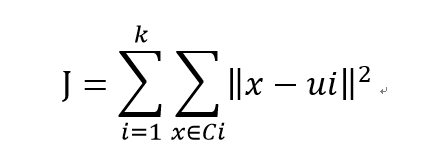


### 导入必要的库 加载数据

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

data = pd.read_csv('../datasets/processed_data_pca.csv')
X = data.values

### 手写实现kmeans算法

In [2]:
class MyKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=42, init="random", distance_metric="euclidean"):
        """
        初始化 KMeans 算法
        参数:
        n_clusters : int, 聚类数
        max_iter : int, 最大迭代次数
        tol : float, 收敛阈值
        random_state : int, 随机种子
        init : str, 初始化方法 ('random' or 'k-means++')
        distance_metric: str, 距离度量方法 ('euclidean', 'manhattan', 'cosine')
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.init = init  # 初始化方法
        self.distance_metric = distance_metric
        self.centers = None  # 存储聚类中心
        self.labels = None   # 存储每个数据点的聚类标签

    def _initialize_centers(self, X):
        """
        初始化聚类中心
        - 当 init='random' 时，随机选择初始中心
        - 当 init='k-means++' 时，使用 k-means++ 方法初始化中心
        """
        rng = np.random.RandomState(self.random_state)
        n_samples = X.shape[0]

        if self.init == "random":
            # 随机选择初始聚类中心
            centers = X[rng.choice(n_samples, self.n_clusters, replace=False)]
        elif self.init == "k-means++":
            # 使用 k-means++ 初始化
            centers = [X[rng.choice(n_samples)]]  # 随机选择第一个中心
            for _ in range(1, self.n_clusters):
                distances = np.min(
                    np.linalg.norm(X[:, np.newaxis] - np.array(centers), axis=2), axis=1
                )
                probabilities = distances / np.sum(distances)
                next_center = X[np.argmax(probabilities)]
                centers.append(next_center)
            centers = np.array(centers)
        else:
            raise ValueError(f"Unsupported init method: {self.init}")
        
        return centers

    def _compute_distances(self, X, centers):
        """
        根据指定的距离度量方法计算每个数据点到所有簇中心的距离
        """
        if self.distance_metric == "euclidean":
            return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        elif self.distance_metric == "manhattan":
            return np.sum(np.abs(X[:, np.newaxis] - centers), axis=2)
        elif self.distance_metric == "cosine":
            # 计算余弦距离
            dot_product = np.dot(X, centers.T)
            X_norm = np.linalg.norm(X, axis=1)
            centers_norm = np.linalg.norm(centers, axis=1)
            cosine_similarity = dot_product / (X_norm[:, None] * centers_norm[None, :])
            return 1 - cosine_similarity  # 转化为距离
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

    def fit(self, X):
        """
        训练 KMeans 模型
        参数:
        X : ndarray, 数据集 (n_samples, n_features)
        """
        n_samples, n_features = X.shape

        # 初始化聚类中心
        self.centers = self._initialize_centers(X)

        for iteration in range(self.max_iter):
            # 计算每个数据点到所有簇中心的距离
            distances = self._compute_distances(X, self.centers)
            # 分配每个数据点到最近的簇
            self.labels = np.argmin(distances, axis=1)

            # 计算新的聚类中心
            new_centers = np.array([X[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])

            # 检查收敛条件
            if np.linalg.norm(new_centers - self.centers) < self.tol:
                print(f"KMeans converged at iteration {iteration + 1}")
                break

            self.centers = new_centers
    @staticmethod
    def plot_elbow(X, max_k=10):
        """
        绘制肘部图以确定最佳聚类数
        参数:
        X : ndarray, 数据集
        max_k : int, 最大的聚类数
        """
        sse = []
        for k in range(1, max_k + 1):
            kmeans = MyKMeans(n_clusters=k, max_iter=100, tol=1e-4, random_state=42)
            kmeans.fit(X)
            # 计算 SSE
            distances = np.linalg.norm(X[:, np.newaxis] - kmeans.centers, axis=2)
            cluster_distances = np.min(distances, axis=1)
            sse.append(np.sum(cluster_distances ** 2))
        
        # 绘制肘部图
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, max_k + 1), sse, marker='o', linestyle='--')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Sum of Squared Errors (SSE)')
        plt.title('Elbow Method for Optimal k')
        plt.xticks(range(1, max_k + 1))
        plt.grid(True)
        plt.show()
    
     

### 绘制肘部图，确定最佳聚类数

KMeans converged at iteration 2
KMeans converged at iteration 8
KMeans converged at iteration 6
KMeans converged at iteration 12
KMeans converged at iteration 11
KMeans converged at iteration 52
KMeans converged at iteration 35
KMeans converged at iteration 20
KMeans converged at iteration 32
KMeans converged at iteration 28


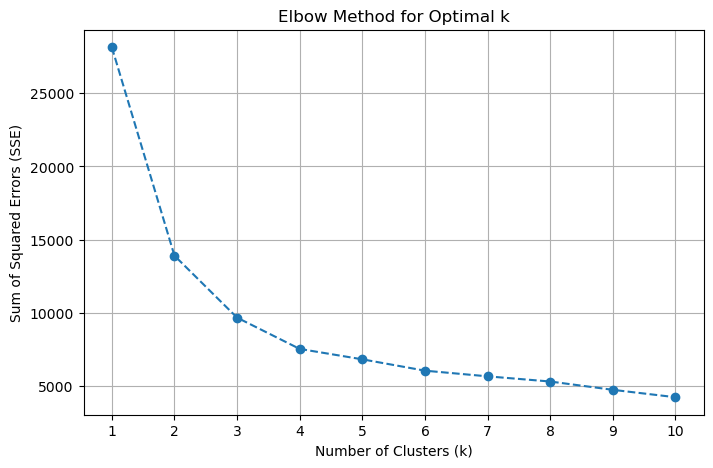

In [3]:
MyKMeans.plot_elbow(X, max_k=10)

### K-Means Or kmeans++ Clustering

In [4]:
random_mykmeans = MyKMeans(n_clusters=4,max_iter=100, random_state=42, init='random')
random_mykmeans.fit(X)
plus_mykmeans = MyKMeans(n_clusters=4,max_iter=100, random_state=42, init='k-means++')
plus_mykmeans.fit(X)

KMeans converged at iteration 12
KMeans converged at iteration 18


In [5]:
# 获取聚类标签
random_mylabels = random_mykmeans.labels
plus_mylabels = plus_mykmeans.labels
# 计算轮廓系数
random_my_silhouette_avg = silhouette_score(X,random_mylabels )
print(f"random_Silhouette Coefficient: {random_my_silhouette_avg}")

# 计算 Calinski-Harabasz 指数
random_my_calinski_harabasz = calinski_harabasz_score(X, random_mylabels)
print(f"random_Calinski-Harabasz Index: {random_my_calinski_harabasz}")

# 计算轮廓系数
plus_my_silhouette_avg = silhouette_score(X,plus_mylabels )
print(f"plus_random_Silhouette Coefficient: {plus_my_silhouette_avg}")

# 计算 Calinski-Harabasz 指数
plus_my_calinski_harabasz = calinski_harabasz_score(X, plus_mylabels)
print(f"plus_Calinski-Harabasz Index: {plus_my_calinski_harabasz}")

random_Silhouette Coefficient: 0.3731871936044875
random_Calinski-Harabasz Index: 2005.4406878663453
plus_random_Silhouette Coefficient: 0.3731457738398309
plus_Calinski-Harabasz Index: 2005.4396469509907


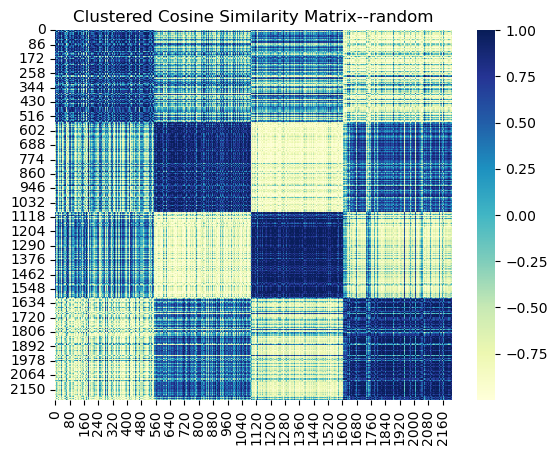

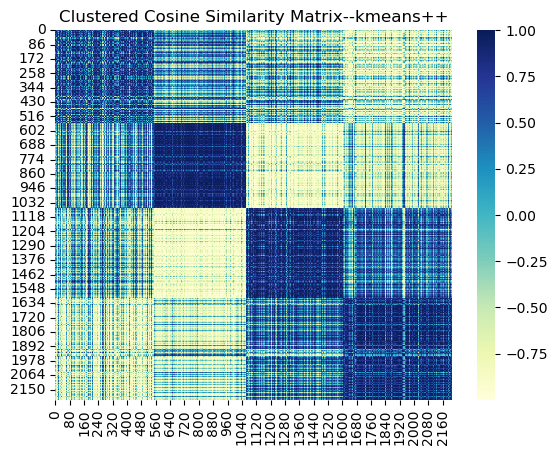

In [6]:
# 计算余弦相似度矩阵
similarity_matrix = cosine_similarity(X)
# 按聚类标签排序
random_my_sorted_indices = np.argsort(random_mylabels)
random_my_sorted_similarity_matrix = similarity_matrix[random_my_sorted_indices][:, random_my_sorted_indices]

plus_my_sorted_indices = np.argsort(plus_mylabels)
plus_my_sorted_similarity_matrix = similarity_matrix[plus_my_sorted_indices][:, plus_my_sorted_indices]

# 可视化排序后的相似矩阵
sns.heatmap(random_my_sorted_similarity_matrix, cmap='YlGnBu')
plt.title('Clustered Cosine Similarity Matrix--random')
plt.show()

# 可视化排序后的相似矩阵
sns.heatmap(plus_my_sorted_similarity_matrix, cmap='YlGnBu')
plt.title('Clustered Cosine Similarity Matrix--kmeans++')
plt.show()


### 聚类结果可视化

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


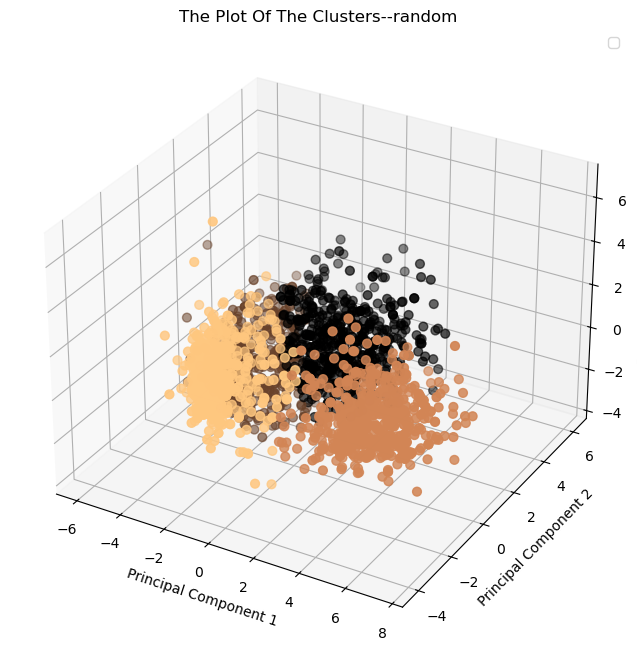

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


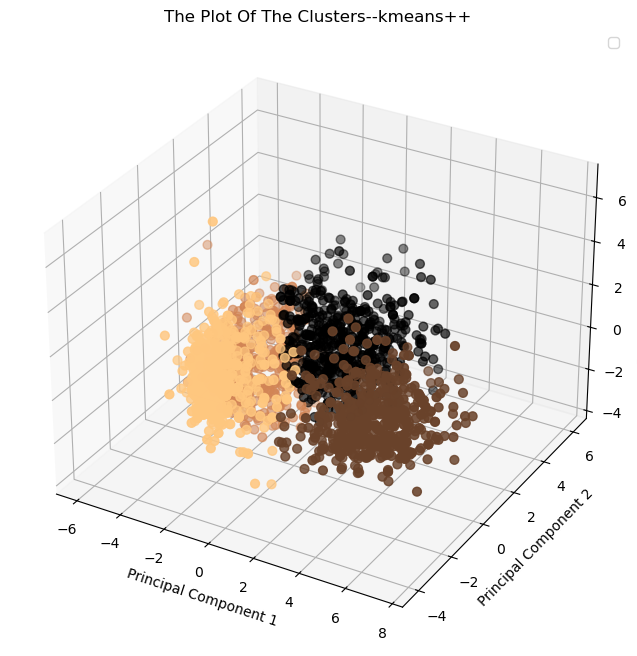

In [7]:
# 绘制 3D 聚类结果
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d')

# 绘制数据点
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=40, c=random_mylabels, marker='o', cmap='copper')


# 设置标题和标签
ax.set_title("The Plot Of The Clusters--random")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# 显示图例
plt.legend()
plt.show()
# 绘制 3D 聚类结果
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d')

# 绘制数据点
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=40, c=plus_mylabels, marker='o', cmap='copper')


# 设置标题和标签
ax.set_title("The Plot Of The Clusters--kmeans++")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# 显示图例
plt.legend()
plt.show()

### 与库函数对比

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
# 获取聚类标签
labels = kmeans.labels_

# 计算轮廓系数
silhouette_avg = silhouette_score(X,labels )
print(f"Silhouette Coefficient: {silhouette_avg}")

# 计算 Calinski-Harabasz 指数
calinski_harabasz = calinski_harabasz_score(X,labels )
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

e:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Coefficient: 0.3734546862138573
Calinski-Harabasz Index: 2005.298501146125


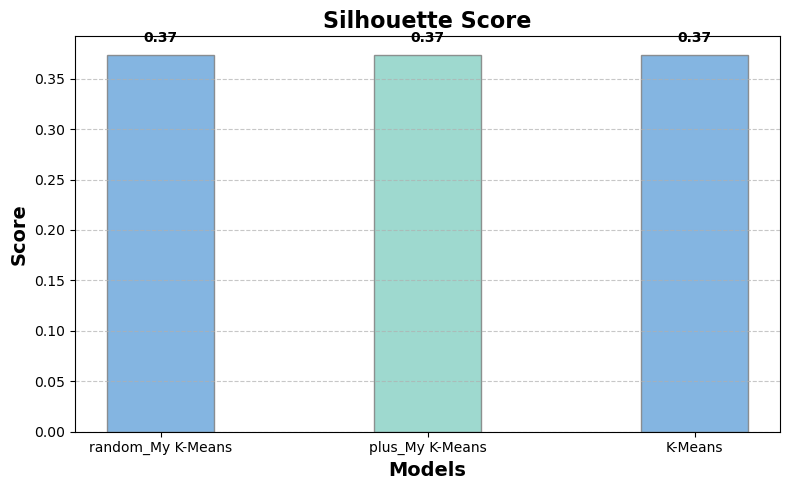

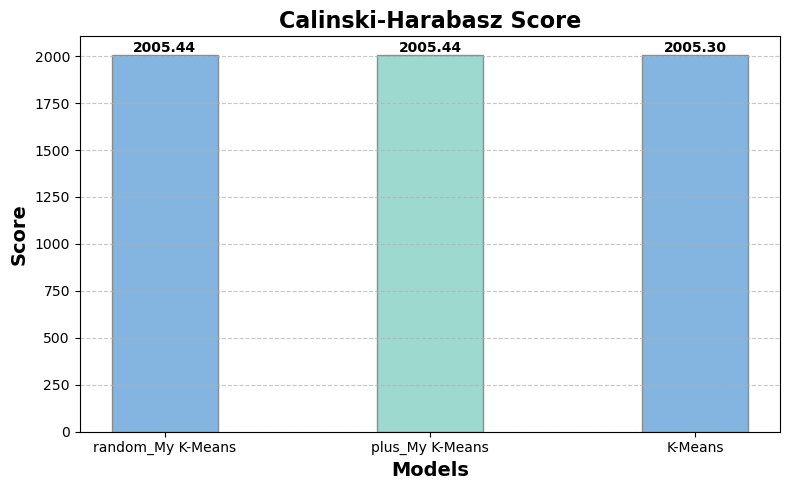

In [9]:
# 模型和 alpha 设置
model_labels = [
    'random_My K-Means',
    'plus_My K-Means',    
    'K-Means'
]

# 假设已经计算好的每种模型的表现指标
total_silhouette_scores = [random_my_silhouette_avg, plus_my_silhouette_avg,silhouette_avg]
total_calinski_harabasz_scores = [random_my_calinski_harabasz, plus_my_calinski_harabasz,calinski_harabasz]

# 准备绘图
metrics = ['轮廓系数', 'Calinski-Harabasz 指数']
scores = [total_silhouette_scores, total_calinski_harabasz_scores]

# 配色
colors = ['#6fa8dc', '#8dd3c7']

# 图 1: 轮廓系数
plt.figure(figsize=(8, 5))
x = np.arange(len(model_labels))  # x 轴为模型数量
width = 0.4  # 柱宽
bars = plt.bar(x, total_silhouette_scores, color=colors, alpha=0.85, edgecolor='grey', width=width)

# 在每个柱子上标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

# 添加标题和标签
plt.title('Silhouette Score', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.xticks(x, model_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 图 2: Calinski-Harabasz 指数
plt.figure(figsize=(8, 5))
x = np.arange(len(model_labels))  # x 轴为模型数量
bars = plt.bar(x, total_calinski_harabasz_scores, color=colors, alpha=0.85, edgecolor='grey', width=width)

# 在每个柱子上标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

# 添加标题和标签
plt.title('Calinski-Harabasz Score', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.xticks(x, model_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [10]:
e_mykmeans = MyKMeans(n_clusters=4,max_iter=100, random_state=42, distance_metric='euclidean')
e_mykmeans.fit(X)
m_mykmeans = MyKMeans(n_clusters=4,max_iter=100, random_state=42, distance_metric='manhattan')
m_mykmeans.fit(X)
c_mykmeans = MyKMeans(n_clusters=4,max_iter=100, random_state=42, distance_metric='cosine')
c_mykmeans.fit(X)

KMeans converged at iteration 12
KMeans converged at iteration 18
KMeans converged at iteration 9


In [11]:
# 获取聚类标签
e_mylabels = e_mykmeans.labels
m_mylabels = m_mykmeans.labels
c_mylabels = c_mykmeans.labels
# 计算轮廓系数
e_my_silhouette_avg = silhouette_score(X,e_mylabels )
print(f"e_Silhouette Coefficient: {e_my_silhouette_avg}")
m_my_silhouette_avg = silhouette_score(X,m_mylabels )
print(f"m_Silhouette Coefficient: {m_my_silhouette_avg}")
c_my_silhouette_avg = silhouette_score(X,c_mylabels )
print(f"c_Silhouette Coefficient: {c_my_silhouette_avg}")
# 计算 Calinski-Harabasz 指数
e_my_calinski_harabasz = calinski_harabasz_score(X, e_mylabels)
print(f"e_Calinski-Harabasz Index: {e_my_calinski_harabasz}")
m_my_calinski_harabasz = calinski_harabasz_score(X, m_mylabels)
print(f"m_Calinski-Harabasz Index: {m_my_calinski_harabasz}")
c_my_calinski_harabasz = calinski_harabasz_score(X, c_mylabels)
print(f"c_Calinski-Harabasz Index: {c_my_calinski_harabasz}")

e_Silhouette Coefficient: 0.3731871936044875
m_Silhouette Coefficient: 0.3649262012350179
c_Silhouette Coefficient: 0.36050953088558907
e_Calinski-Harabasz Index: 2005.4406878663453
m_Calinski-Harabasz Index: 1963.2297686543254
c_Calinski-Harabasz Index: 1909.961536163491


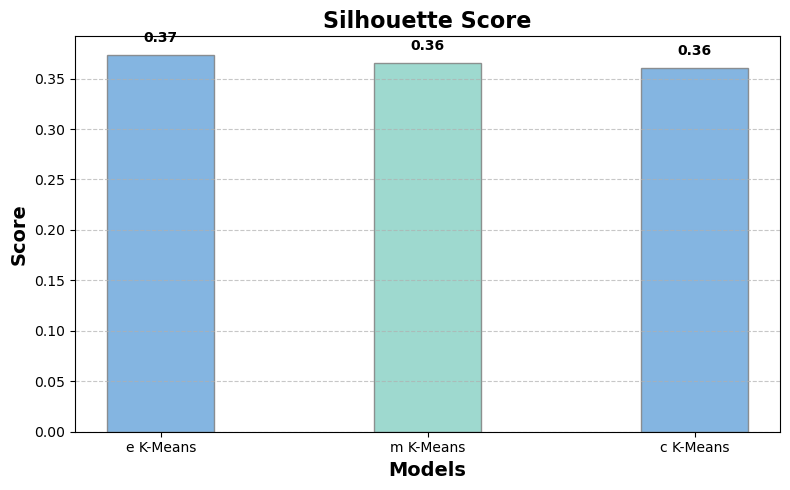

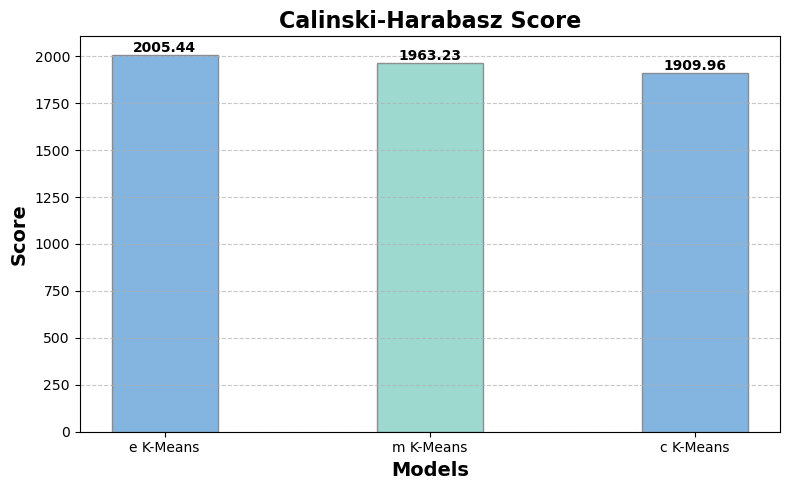

In [12]:
# 模型和 alpha 设置
model_labels = [
    'e K-Means',
    'm K-Means',    
    'c K-Means'
]

# 假设已经计算好的每种模型的表现指标
total_silhouette_scores = [e_my_silhouette_avg, m_my_silhouette_avg,c_my_silhouette_avg]
total_calinski_harabasz_scores = [e_my_calinski_harabasz, m_my_calinski_harabasz,c_my_calinski_harabasz]

# 准备绘图
metrics = ['轮廓系数', 'Calinski-Harabasz 指数']
scores = [total_silhouette_scores, total_calinski_harabasz_scores]

# 配色
colors = ['#6fa8dc', '#8dd3c7']

# 图 1: 轮廓系数
plt.figure(figsize=(8, 5))
x = np.arange(len(model_labels))  # x 轴为模型数量
width = 0.4  # 柱宽
bars = plt.bar(x, total_silhouette_scores, color=colors, alpha=0.85, edgecolor='grey', width=width)

# 在每个柱子上标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

# 添加标题和标签
plt.title('Silhouette Score', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.xticks(x, model_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 图 2: Calinski-Harabasz 指数
plt.figure(figsize=(8, 5))
x = np.arange(len(model_labels))  # x 轴为模型数量
bars = plt.bar(x, total_calinski_harabasz_scores, color=colors, alpha=0.85, edgecolor='grey', width=width)

# 在每个柱子上标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

# 添加标题和标签
plt.title('Calinski-Harabasz Score', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.xticks(x, model_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()